In [38]:
import tensorflow as tf
import numpy as np

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from db import DB
from datetime import datetime

In [220]:
mydb = DB(20201114, 4)
EXC = ['bitflyer', 'liquid', 'zaif', 'coincheck']
baseTime = datetime(2020, 11, 14, 0, 0, 0).timestamp()

def ml(func, array):
    return list(map(func, array))
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [115]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [372]:
import gym
from gym import spaces

NONE = 0
BUY = 1
SELL = 2

BUYAMOUNT = 0.01
DIVP = 1000000
EXLEN = len(EXC)
N_ACTIONS = 8

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['console']}

  def __init__(self):
    super(CustomEnv, self).__init__()
    self.action_space = spaces.MultiBinary(N_ACTIONS)
    self.observation_space = spaces.Box(low=0, high=100,
                                        shape=(968,),dtype=np.float32)
    self.asks = {}
    self.bids = {}
    self.maxCnt = 0
    for ex in EXC:
      prices = mydb.get(ex, baseTime, baseTime + 60*60*24)
      # 1分単位に修正
      #prices = prices[250*20::1]
      # example for self.asks[ex]
      # [[[1701256.0, 0.0001], [1701501.0, 0.005], [1701505.0, 0.01015336]],
      # [[1701316.0, 0.01], [1701494.0, 0.01275137], [1701500.0, 0.02]],
      # [[1702132.0, 0.02440992], [1702180.0, 0.1], [1702290.0, 0.08]]]
      self.asks[ex] = ml(lambda p:p['asks'], prices)
      self.bids[ex] = ml(lambda p:p['bids'], prices)
      self.maxCnt = max([self.maxCnt, len(self.asks[ex])-3])
    self.initVal()

  def initVal(self):
    self.episode_ended = False
    # ランダム時間から開始
    #self.stepCnt = np.random.randint(0, self.maxCnt-129)
    self.stepCnt = 0
    self.startCnt = self.stepCnt
    # ランダムな所持金で開始
    #jpy = (np.random.randint(10000, 1000000, EXLEN) / DIVP).tolist()
    #btc = (abs(np.random.randn(EXLEN))+0.01).tolist()
    jpy = [0.1] * EXLEN
    btc = [0.1] * EXLEN
    self.state = jpy + btc + [0]*960
    self.step(np.array([0]*N_ACTIONS))
    self.initJPY = self.valuationJPY(self.state)
    self.initBTC = self.valuationBTC(self.state)
    self.prevReward = 0

  def reset(self):
    print('reset')
    self.initVal()
    return np.array(self.state).astype(np.float32)

  # 円換算評価額
  def valuationJPY(self, state):
    total = 0
    for i in range(EXLEN):
      jpy = self.state[i]
      btc = self.state[EXLEN + i]
      ask = self.state[int(EXLEN*2)]
      total += jpy + btc * ask
    return total

  # BTC換算評価額
  def valuationBTC(self, state):
    total = 0
    for i in range(EXLEN):
      jpy = self.state[i]
      btc = self.state[EXLEN + i]
      ask = self.state[int(EXLEN*2)]
      total += btc
      if ask > 0:
        total += jpy / ask
    return total

  def amountReward(self):
    jpy = self.valuationJPY(self.state)
    btc = self.valuationBTC(self.state)
    # 初期所持金から何倍増えたかが報酬
    return jpy / self.initJPY + btc / self.initBTC - 2

  def trade(self, exidx, buy):
    cnt = self.stepCnt
    ex = EXC[exidx]
    jpyBal = self.state[0:EXLEN]
    btcBal = self.state[EXLEN:EXLEN*2]
    # 売買 次のフレームの価格で購入できる
    if buy:
      target = self.asks[ex][cnt+1:cnt+2][0]
      # 買える分だけ買う
      remain = BUYAMOUNT
      for dep in range(3):
        price = target[dep][0]
        amount = target[dep][1]
        if remain <= amount:
          amount = remain
        jpy = price * amount
        if jpyBal[exidx] < jpy:
          self.reward -= 1.0 # 買えない場合ペナルティ
          break
        jpyBal[exidx] -= jpy
        btcBal[exidx] += amount
        remain -= amount
        if remain <= 0:
          break
    else:
      target = self.bids[ex][cnt+1:cnt+2][0]
      # 売れる分だけ売る
      remain = BUYAMOUNT
      for dep in range(3):
        price = target[dep][0]
        amount = target[dep][1]
        if remain <= amount:
          amount = remain
        if btcBal[exidx] < amount:
          self.reward -= 1.0 # 売れない場合ペナルティ
          break
        jpyBal[exidx] += price * amount
        btcBal[exidx] -= amount
        remain -= amount
        if remain <= 0:
          break
    self.state[0:EXLEN] = jpyBal
    self.state[EXLEN:EXLEN*2] = btcBal

  def step(self, action):
    cnt = self.stepCnt
    self.reward = 0.0
    # stateから情報を抜出
    board = self.state[EXLEN*2:EXLEN*2+960]

    # 1フレーム前の板情報を反映
    frameSize = int(len(board) / 20)
    board[frameSize:len(board)] = board[0:(len(board)-frameSize)]

    # 最新板情報を更新
    cur = 0
    for ex in EXC:
      for ab in [self.asks, self.bids]:
        for dep in range(3):
          # 金額
          board[cur] = ab[ex][cnt:cnt+1][0][dep][0]
          cur += 1
          # 量
          board[cur] = ab[ex][cnt:cnt+1][0][dep][1]
          cur += 1

    # Make sure episodes don't go on forever.
    for i in range(len(action)):
      if action[i] == 1:
        exidx = i % EXLEN
        buy = i < EXLEN
        self.trade(exidx, buy)

    # state更新
    jpyBal = self.state[0:EXLEN]
    btcBal = self.state[EXLEN:EXLEN*2]
    self.state = jpyBal + btcBal + board

    # 3秒時間を進める
    self.stepCnt += 1
    if self.stepCnt >= self.maxCnt:
      self.episode_ended = True

    # 最大128フレームで終了
    frameCnt = self.stepCnt - self.startCnt
    #if frameCnt > 128:
    #  self.episode_ended = True
    
    diff = 0.0
    info = {
      'stepCnt': self.stepCnt
    }
    if frameCnt > 1:
      diff = self.amountReward()
      if self.prevReward != 0:
        self.reward += diff - self.prevReward
      self.prevReward = diff
      info['jpy'] = self.valuationJPY(self.state)
    
    # 残高を記録
    jpyBal = self.state[0:EXLEN]
    btcBal = self.state[EXLEN:EXLEN*2]
    for i in range(len(EXC)):
      info[f'jpy{EXC[i]}'] = jpyBal[i]
      info[f'btc{EXC[i]}'] = btcBal[i]
    
    if self.episode_ended:
      self.reward = diff

    return np.array(self.state).astype(np.float32), self.reward*128, self.episode_ended, info

  def plot(self):
    x =  range(0, self.maxCnt+3)
    base = np.array(ml(lambda a:a[0][0], self.asks['bitflyer']))
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
    for ex in EXC:
      ay = np.array(ml(lambda a:a[0][0], self.asks[ex]))
      axL.plot(x, ay - base, label=f'ask {ex}')
      by = np.array(ml(lambda a:a[0][0], self.bids[ex]))
      axR.plot(x, by - base, label=f'bid {ex}')
    axL.set_title('ask diff')
    axR.set_title('bid diff')
    fig.legend()
    fig.show()

  def plotPrice(self):
    for ex in EXC:
      plt.plot(ml(lambda a:a[0][0], self.asks[ex]))

  def render(self, mode='console'):
    if mode != 'console':
      raise NotImplementedError()
    # agent is represented as a cross, rest as a dot
    print("jpy:", self.valuationJPY(self.state))

  def close(self):
    pass

reset


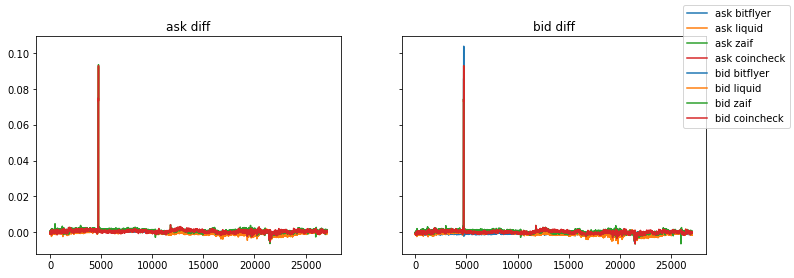

In [373]:
env = CustomEnv()
check_env(env, warn=True)
env.plot()

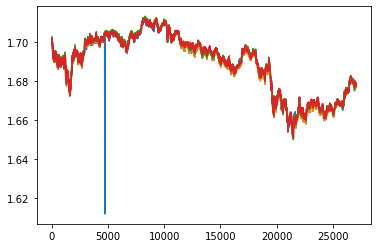

In [374]:
env.plotPrice()

In [375]:
log_dir = "baselog"
os.makedirs(log_dir, exist_ok=True)
env = CustomEnv()
env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000, callback=callback)

obs = env.reset()
per = 30
actions = []
jpys = []
jpya = {}
btca = {}
for ex in EXC:
    jpya[ex] = []
    btca[ex] = []
for i in range(1200):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    actions.append(action)
    jpys.append(info['jpy'])
    for ex in EXC:
      jpya[ex].append(info[f'jpy{ex}'])
      btca[ex].append(info[f'btc{ex}'])
    if i % per == 0:
      print(action)
    if done:
      print(info)
      # env.render()
      obs = env.reset()
      break

env.close()

de: -100.61
Num timesteps: 65000
Best mean reward: -100.61 - Last mean reward per episode: -100.61
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.71e+04    |
|    ep_rew_mean          | -101        |
| time/                   |             |
|    fps                  | 447         |
|    iterations           | 32          |
|    time_elapsed         | 146         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.029805247 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.42       |
|    explained_variance   | 0.24        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0487     |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0212     |
|    value_loss           | 0.00104     |
-----------------------------------------
Num timesteps: 6600

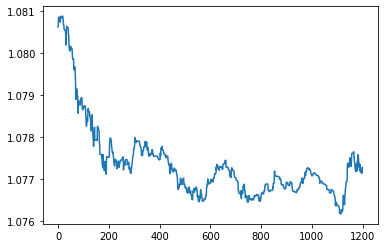

In [376]:
plt.plot(jpys)

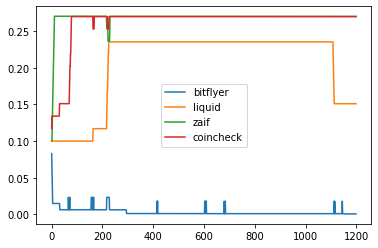

In [377]:
for ex in EXC:
    plt.plot(jpya[ex], label=ex)
plt.legend()

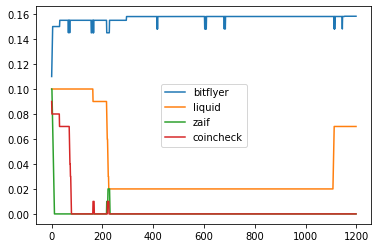

In [378]:
for ex in EXC:
    plt.plot(btca[ex], label=ex)
plt.legend()

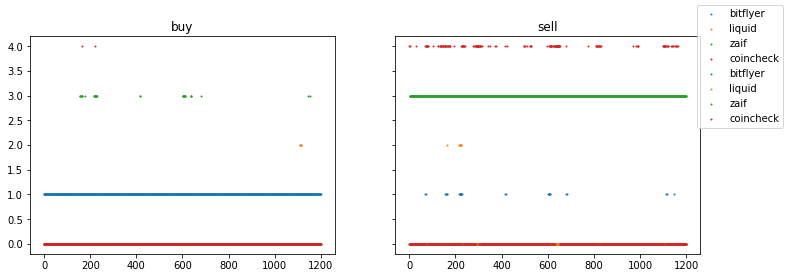

In [379]:
x =  range(0, len(actions))
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
for i in range(len(EXC)):
    by = ml(lambda a:a[i]*(i+1), actions)
    axL.scatter(x, by, label=EXC[i], s=1)
    axL.set_title('buy')
    sy = ml(lambda a:a[i+len(EXC)]*(i+1), actions)
    axR.scatter(x, sy, label=EXC[i], s=1)
    axR.set_title('sell')
fig.legend()
fig.show()

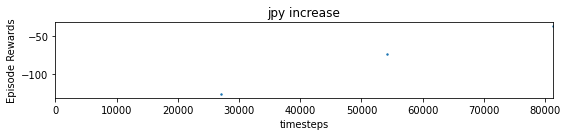

In [380]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "jpy increase")

In [114]:
def evaluate(model, num_episodes=100):
    """
    RLエージェントを評価
    :param model: (BaseRLModel object) RLエージェント
    :param num_episodes: (int) エピソード数
    :return: (float) 平均報酬
    """
    # この関数は単一の環境でのみ機能します
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _statesは、LSTMポリシーを使用する場合にのみ有用です
            action, _states = model.predict(obs)

            # ベクトル化環境を使用しているため、行動、報酬、エピソード完了は配列です
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward